In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf
import pandas as pd

# Import src code
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.overfitting_test import *
from src.data.create_dataset import dataset_tf
from src.data.path_loader import PathLoader

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 64
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 64
EPOCHS = 100
T = int(config_hp["T"])  # number of diffusion steps
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

In [4]:
# Load csv data
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

# Show the df
df

,name,pokedex_id,type1,type2,image_fn
0,Bulbasaur,1,Grass,Poison,['1']
1,Ivysaur,2,Grass,Poison,['2']
2,Venusaur,3,Grass,Poison,['3']
3,Venusaur Gmax,3,Grass,Poison,['3_g']
4,Venusaur Mega,3,Grass,Poison,['3_2']
...,...,...,...,...,...
1113,Glastrier,896,Ice,NaN,['896']
1114,Spectrier,897,Ghost,NaN,['897']
1115,Calyrex,898,Psychic,Grass,['898_1']
1116,Calyrex Ice Rider,898,Psychic,Ice,['898_2']


- The shape of the dataset is: (64, 64, 64, 3) => batch_size: 64, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (64, 18) => batch_size: 64, number of labels: 18


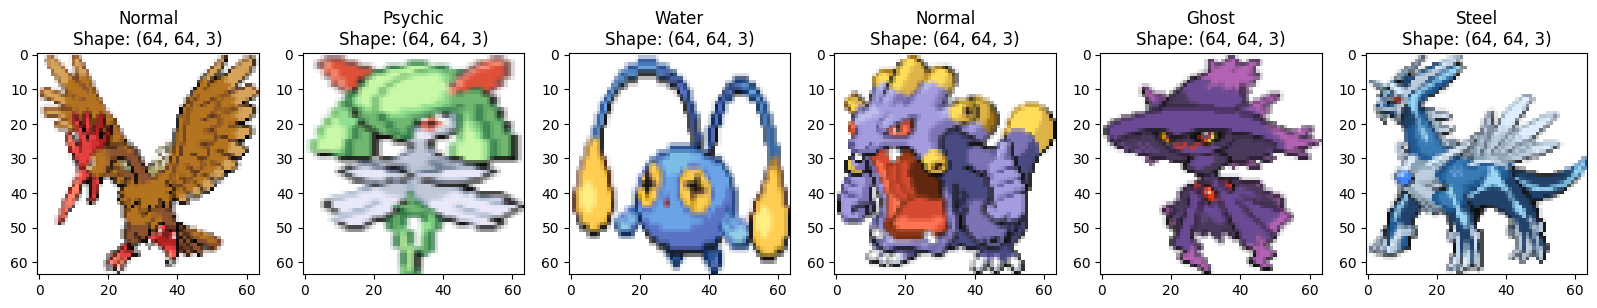

In [10]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    image_paths=PathLoader.get_image_paths(f"{DATA_PATH}/interim/image_paths.json"),
    df=df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    save=False,
    save_path=dataset_path,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [11]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

Epoch 1/100


I0000 00:00:1714433642.906990     921 service.cc:145] XLA service 0x759fbc0041e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714433642.907025     921 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1714433643.322142     921 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1714433644.860392    1417 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5377', 440 bytes spill stores, 440 bytes spill loads

I0000 00:00:1714433645.105225    1424 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5377', 492 bytes spill stores, 492 bytes spill loads

I0000 00:00:1714433662.826891     921 device_compiler.h:188] Com

63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 168ms/step - loss: 0.7283
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.2182
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.1900
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.1296
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0971
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0959
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.1186
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.1186
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.1004
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0609
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0622
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0980
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.1027
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.1019
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1

Sampling sprite: 1000it [00:45, 22.01it/s]                        


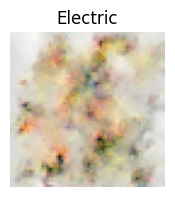

63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 910ms/step - loss: 0.0770
Epoch 21/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0536
Epoch 22/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0574
Epoch 23/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0939
Epoch 24/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0775
Epoch 25/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0569
Epoch 26/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0622
Epoch 27/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.1050
Epoch 28/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.1026
Epoch 29/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0498
Epoch 30/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0795
Epoch 31/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0795
Epoch 32/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0625
Epoch 33/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0901
Epoch 34/100
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 1000it [00:43, 22.96it/s]                        


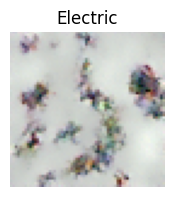

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 882ms/step - loss: 0.0567
Epoch 41/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0653
Epoch 42/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0848
Epoch 43/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0479
Epoch 44/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0532
Epoch 45/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0498
Epoch 46/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0594
Epoch 47/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0844
Epoch 48/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0529
Epoch 49/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0577
Epoch 50/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0721
Epoch 51/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0466
Epoch 52/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0362
Epoch 53/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0352
Epoch 54/100
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 1000it [00:43, 23.00it/s]                        


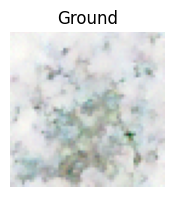

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 881ms/step - loss: 0.0948
Epoch 61/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0596
Epoch 62/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0796
Epoch 63/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0458
Epoch 64/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0856
Epoch 65/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0480
Epoch 66/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0603
Epoch 67/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0803
Epoch 68/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0587
Epoch 69/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0704
Epoch 70/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0815
Epoch 71/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0608
Epoch 72/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0470
Epoch 73/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0456
Epoch 74/100
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 1000it [00:42, 23.73it/s]                        


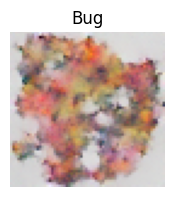

63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 859ms/step - loss: 0.0473
Epoch 81/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.0342
Epoch 82/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 291ms/step - loss: 0.0551
Epoch 83/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - loss: 0.0568
Epoch 84/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - loss: 0.0515
Epoch 85/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0861
Epoch 86/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - loss: 0.0572
Epoch 87/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0587
Epoch 88/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0457
Epoch 89/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0388
Epoch 90/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0651
Epoch 91/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0739
Epoch 92/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0616
Epoch 93/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0625
Epoch 94/100
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 1000it [00:46, 21.46it/s]                        


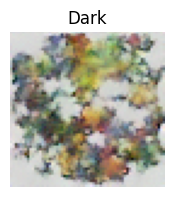

63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 929ms/step - loss: 0.0406


In [12]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0670
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0557
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0499
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.0676
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 0.0607
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0395
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0552
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0440
Epoch 9/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0546
Epoch 10/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0471
Epoch 11/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0437
Epoch 12/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0680
Epoch 13/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0435
Epoch 14/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0461
Epoch 15/500
63/63 ━━━━━━━━━━

Sampling sprite: 1000it [00:44, 22.36it/s]                        


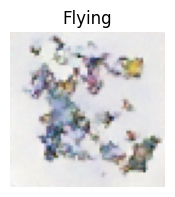

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 906ms/step - loss: 0.0538
Epoch 21/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0427
Epoch 22/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0482
Epoch 23/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.0384
Epoch 24/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0333
Epoch 25/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0503
Epoch 26/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0608
Epoch 27/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0493
Epoch 28/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0468
Epoch 29/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0436
Epoch 30/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - loss: 0.0589
Epoch 31/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0654
Epoch 32/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0664
Epoch 33/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0576
Epoch 34/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 1000it [00:43, 23.07it/s]                        


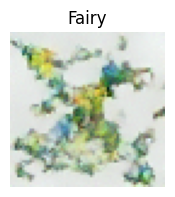

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 886ms/step - loss: 0.0557
Epoch 41/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0591
Epoch 42/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.1037
Epoch 43/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0629
Epoch 44/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.0484
Epoch 45/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0394
Epoch 46/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.0467
Epoch 47/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0628
Epoch 48/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0665
Epoch 49/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0786
Epoch 50/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0321
Epoch 51/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - loss: 0.0333
Epoch 52/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0532
Epoch 53/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0553
Epoch 54/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 1000it [00:43, 23.00it/s]                        


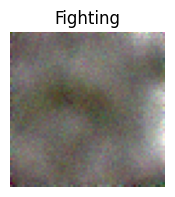

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 887ms/step - loss: 0.0299
Epoch 61/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0925
Epoch 62/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0658
Epoch 63/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0508
Epoch 64/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.0498
Epoch 65/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0465
Epoch 66/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.0316
Epoch 67/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0538
Epoch 68/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0365
Epoch 69/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0370
Epoch 70/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0646
Epoch 71/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0581
Epoch 72/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0379
Epoch 73/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0598
Epoch 74/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 1000it [00:43, 23.06it/s]                        


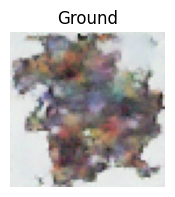

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 883ms/step - loss: 0.0409
Epoch 81/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0641
Epoch 82/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0512
Epoch 83/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0401
Epoch 84/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.0493
Epoch 85/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0389
Epoch 86/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.0366
Epoch 87/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0447
Epoch 88/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0468
Epoch 89/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0395
Epoch 90/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0549
Epoch 91/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0492
Epoch 92/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0578
Epoch 93/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0378
Epoch 94/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 1000it [00:43, 22.88it/s]                        


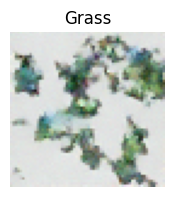

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 891ms/step - loss: 0.0932
Epoch 101/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0403
Epoch 102/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0364
Epoch 103/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0422
Epoch 104/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.0725
Epoch 105/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0686
Epoch 106/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.1058
Epoch 107/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 0.0569
Epoch 108/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0519
Epoch 109/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0811
Epoch 110/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0571
Epoch 111/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0335
Epoch 112/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0445
Epoch 113/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0455
Epoch 114/500
63/63 

Sampling sprite: 1000it [00:43, 22.87it/s]                        


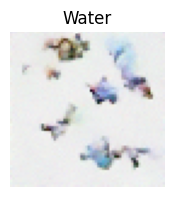

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 891ms/step - loss: 0.0481
Epoch 121/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0851
Epoch 122/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0579
Epoch 123/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0528
Epoch 124/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.0665
Epoch 125/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0479
Epoch 126/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.0623
Epoch 127/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0624
Epoch 128/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0678
Epoch 129/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0880
Epoch 130/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0442
Epoch 131/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0421
Epoch 132/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0493
Epoch 133/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0520
Epoch 134/500
63/63 

Sampling sprite: 1000it [00:43, 23.06it/s]                        


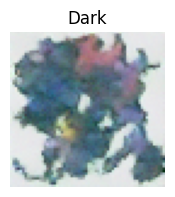

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 887ms/step - loss: 0.0410
Epoch 141/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0769
Epoch 142/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0448
Epoch 143/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0878
Epoch 144/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.0507
Epoch 145/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.0464
Epoch 146/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.0645
Epoch 147/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0591
Epoch 148/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0248
Epoch 149/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0789
Epoch 150/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0392
Epoch 151/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0486
Epoch 152/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0361
Epoch 153/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0424
Epoch 154/500
63/63 

Sampling sprite: 1000it [00:43, 22.95it/s]                        


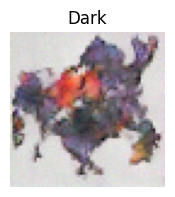

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 888ms/step - loss: 0.0357
Epoch 161/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0685
Epoch 162/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0408
Epoch 163/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0421
Epoch 164/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0610
Epoch 165/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0649
Epoch 166/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 0.0335
Epoch 167/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0481
Epoch 168/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0438
Epoch 169/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0514
Epoch 170/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0314
Epoch 171/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0396
Epoch 172/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0464
Epoch 173/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0283
Epoch 174/500
63/63 

Sampling sprite: 1000it [00:43, 22.81it/s]                        


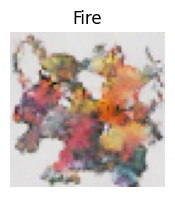

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 894ms/step - loss: 0.0297
Epoch 181/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0532
Epoch 182/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0410
Epoch 183/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0372
Epoch 184/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.0378
Epoch 185/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0347
Epoch 186/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 0.0544
Epoch 187/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0438
Epoch 188/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0317
Epoch 189/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0322
Epoch 190/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0342
Epoch 191/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0592
Epoch 192/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0825
Epoch 193/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0824
Epoch 194/500
63/63 

Sampling sprite: 1000it [00:43, 22.91it/s]                        


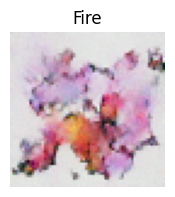

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 890ms/step - loss: 0.0595
Epoch 201/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0642
Epoch 202/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0446
Epoch 203/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0384
Epoch 204/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0536
Epoch 205/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 0.0573
Epoch 206/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 0.0409
Epoch 207/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 0.0377
Epoch 208/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0447
Epoch 209/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0440
Epoch 210/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.1492
Epoch 211/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0872
Epoch 212/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0546
Epoch 213/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0589
Epoch 214/500
63/63 

Sampling sprite: 1000it [00:43, 23.00it/s]                        


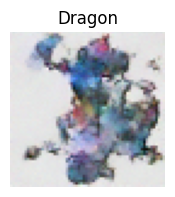

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 890ms/step - loss: 0.0440
Epoch 221/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0817
Epoch 222/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0553
Epoch 223/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0621
Epoch 224/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0365
Epoch 225/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0325
Epoch 226/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 0.0487
Epoch 227/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0462
Epoch 228/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0321
Epoch 229/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0543
Epoch 230/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0479
Epoch 231/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0263
Epoch 232/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0279
Epoch 233/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0472
Epoch 234/500
63/63 

Sampling sprite: 1000it [00:43, 22.91it/s]                        


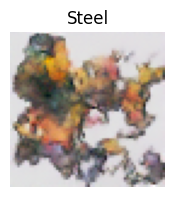

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 891ms/step - loss: 0.0569
Epoch 241/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0688
Epoch 242/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0478
Epoch 243/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0666
Epoch 244/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.0508
Epoch 245/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0309
Epoch 246/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0376
Epoch 247/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0505
Epoch 248/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0252
Epoch 249/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0486
Epoch 250/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0397
Epoch 251/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0416
Epoch 252/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0436
Epoch 253/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0465
Epoch 254/500
63/63 

Sampling sprite: 1000it [00:43, 22.92it/s]                        


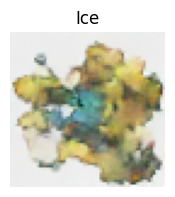

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 892ms/step - loss: 0.0273
Epoch 261/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0535
Epoch 262/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0483
Epoch 263/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.0616
Epoch 264/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0934
Epoch 265/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0712
Epoch 266/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 0.0737
Epoch 267/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0477
Epoch 268/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0347
Epoch 269/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0431
Epoch 270/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0348
Epoch 271/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0403
Epoch 272/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0274
Epoch 273/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0323
Epoch 274/500
63/63 

Sampling sprite: 1000it [00:43, 22.75it/s]                        


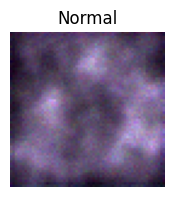

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 896ms/step - loss: 0.0938
Epoch 281/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0371
Epoch 282/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0475
Epoch 283/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0526
Epoch 284/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0466
Epoch 285/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.0448
Epoch 286/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 0.0515
Epoch 287/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0568
Epoch 288/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0384
Epoch 289/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0428
Epoch 290/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0386
Epoch 291/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0274
Epoch 292/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0387
Epoch 293/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0527
Epoch 294/500
63/63 

Sampling sprite: 1000it [00:43, 22.83it/s]                        


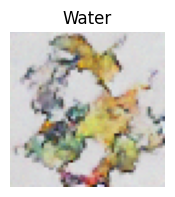

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 894ms/step - loss: 0.0419
Epoch 301/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0434
Epoch 302/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0245
Epoch 303/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0416
Epoch 304/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0375
Epoch 305/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 0.0404
Epoch 306/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0438
Epoch 307/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0489
Epoch 308/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0424
Epoch 309/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0376
Epoch 310/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0494
Epoch 311/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0389
Epoch 312/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0496
Epoch 313/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0426
Epoch 314/500
63/63 

Sampling sprite: 1000it [00:43, 22.87it/s]                        


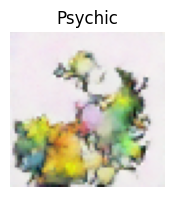

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 895ms/step - loss: 0.0687
Epoch 321/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0283
Epoch 322/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0304
Epoch 323/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0364
Epoch 324/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0470
Epoch 325/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0381
Epoch 326/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.0305
Epoch 327/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0323
Epoch 328/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0563
Epoch 329/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0474
Epoch 330/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0806
Epoch 331/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0297
Epoch 332/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0500
Epoch 333/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0375
Epoch 334/500
63/63 

Sampling sprite: 1000it [00:43, 23.02it/s]                        


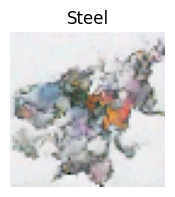

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 891ms/step - loss: 0.0464
Epoch 341/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0500
Epoch 342/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0385
Epoch 343/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0582
Epoch 344/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0407
Epoch 345/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.0399
Epoch 346/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0379
Epoch 347/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0369
Epoch 348/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0293
Epoch 349/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0367
Epoch 350/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0338
Epoch 351/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - loss: 0.0375
Epoch 352/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0384
Epoch 353/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0381
Epoch 354/500
63/63 

Sampling sprite: 1000it [00:44, 22.68it/s]                        


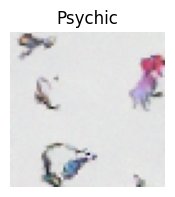

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 899ms/step - loss: 0.0532
Epoch 361/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0471
Epoch 362/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0453
Epoch 363/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0478
Epoch 364/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0564
Epoch 365/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0438
Epoch 366/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0290
Epoch 367/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0301
Epoch 368/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0437
Epoch 369/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0333
Epoch 370/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0579
Epoch 371/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0675
Epoch 372/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0466
Epoch 373/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0584
Epoch 374/500
63/63 

Sampling sprite: 1000it [00:43, 22.99it/s]                        


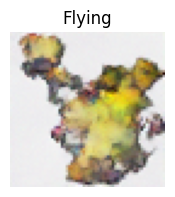

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 889ms/step - loss: 0.0360
Epoch 381/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0595
Epoch 382/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0469
Epoch 383/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0455
Epoch 384/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.0313
Epoch 385/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.0198
Epoch 386/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0587
Epoch 387/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0487
Epoch 388/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0475
Epoch 389/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0608
Epoch 390/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0352
Epoch 391/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0427
Epoch 392/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0401
Epoch 393/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0331
Epoch 394/500
63/63 

Sampling sprite: 1000it [00:43, 22.93it/s]                        


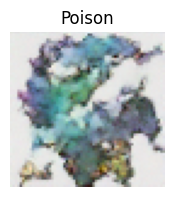

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 891ms/step - loss: 0.0571
Epoch 401/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0591
Epoch 402/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0556
Epoch 403/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0355
Epoch 404/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0367
Epoch 405/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 0.0505
Epoch 406/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0532
Epoch 407/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0497
Epoch 408/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0482
Epoch 409/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0427
Epoch 410/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0453
Epoch 411/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0259
Epoch 412/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0316
Epoch 413/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0484
Epoch 414/500
63/63 

Sampling sprite: 1000it [00:43, 22.92it/s]                        


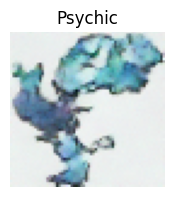

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 894ms/step - loss: 0.0439
Epoch 421/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0245
Epoch 422/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0341
Epoch 423/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0445
Epoch 424/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0601
Epoch 425/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0452
Epoch 426/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0442
Epoch 427/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0378
Epoch 428/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0533
Epoch 429/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0456
Epoch 430/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0436
Epoch 431/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0516
Epoch 432/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0278
Epoch 433/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0400
Epoch 434/500
63/63 

Sampling sprite: 1000it [00:43, 22.75it/s]                        


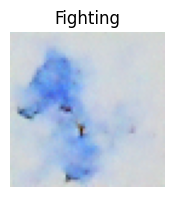

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 898ms/step - loss: 0.0595
Epoch 441/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0522
Epoch 442/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0644
Epoch 443/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0422
Epoch 444/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.0389
Epoch 445/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.0338
Epoch 446/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0543
Epoch 447/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0420
Epoch 448/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0299
Epoch 449/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0709
Epoch 450/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0484
Epoch 451/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0316
Epoch 452/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0396
Epoch 453/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.0335
Epoch 454/500
63/63 

Sampling sprite: 1000it [00:43, 22.86it/s]                        


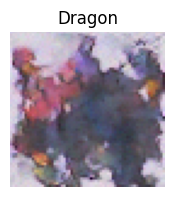

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 893ms/step - loss: 0.0647
Epoch 461/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0505
Epoch 462/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0372
Epoch 463/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0488
Epoch 464/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0725
Epoch 465/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 0.0407
Epoch 466/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 0.0325
Epoch 467/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0364
Epoch 468/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0541
Epoch 469/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0473
Epoch 470/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0342
Epoch 471/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0413
Epoch 472/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0301
Epoch 473/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0343
Epoch 474/500
63/63 

Sampling sprite: 1000it [00:43, 22.98it/s]                        


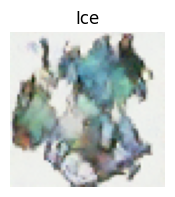

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 889ms/step - loss: 0.0568
Epoch 481/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0582
Epoch 482/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0387
Epoch 483/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0283
Epoch 484/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0533
Epoch 485/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.0775
Epoch 486/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 0.0346
Epoch 487/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0530
Epoch 488/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0354
Epoch 489/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0456
Epoch 490/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0710
Epoch 491/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - loss: 0.0313
Epoch 492/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0379
Epoch 493/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0348
Epoch 494/500
63/63 

Sampling sprite: 1000it [00:43, 22.95it/s]                        


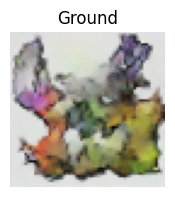

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 892ms/step - loss: 0.0285


In [13]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

Generating sample 1/6


Sampling sprite: 1000it [00:43, 23.20it/s]                        


Generating sample 2/6


Sampling sprite: 1000it [00:41, 23.84it/s]                        


Generating sample 3/6


Sampling sprite: 1000it [00:41, 23.98it/s]                        


Generating sample 4/6


Sampling sprite: 1000it [00:41, 24.05it/s]                        


Generating sample 5/6


Sampling sprite: 1000it [00:41, 23.92it/s]                        


Generating sample 6/6


Sampling sprite: 1000it [00:41, 23.97it/s]                        


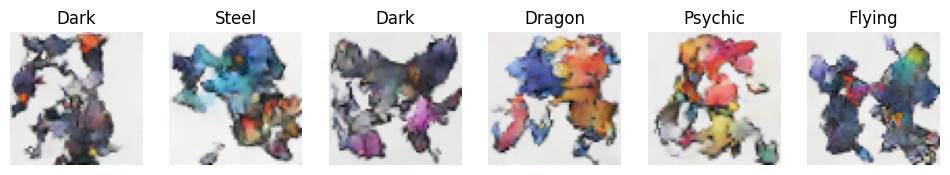

Generating sample 1/3


Sampling sprite: 1000it [00:41, 23.97it/s]                        


Generating sample 2/3


Sampling sprite: 1000it [00:41, 24.14it/s]                        


Generating sample 3/3


Sampling sprite: 1000it [00:41, 24.00it/s]                        


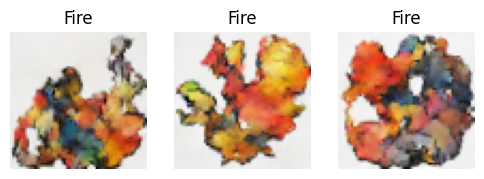

Generating sample 1/3


Sampling sprite: 1000it [00:41, 24.15it/s]                        


Generating sample 2/3


Sampling sprite: 1000it [00:41, 24.19it/s]                        


Generating sample 3/3


Sampling sprite: 1000it [00:41, 24.27it/s]                        


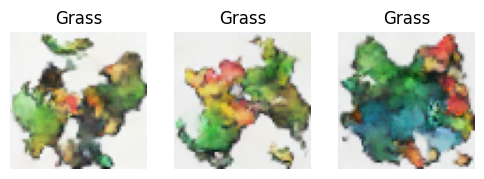

Generating sample 1/3


Sampling sprite: 1000it [00:41, 24.13it/s]                        


Generating sample 2/3


Sampling sprite: 1000it [00:41, 24.14it/s]                        


Generating sample 3/3


Sampling sprite: 1000it [00:41, 24.23it/s]                        


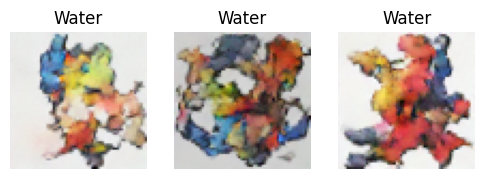

In [14]:
model.plot_samples(6)

model.plot_samples(3, "Fire")
model.plot_samples(3, "Grass")
model.plot_samples(3, "Water")

Generating sample 1/6


Sampling sprite: 1000it [00:41, 24.33it/s]                        


Generating sample 2/6


Sampling sprite: 1000it [00:40, 24.47it/s]                        


Generating sample 3/6


Sampling sprite: 1000it [00:40, 24.44it/s]                        


Generating sample 4/6


Sampling sprite: 1000it [00:40, 24.47it/s]                        


Generating sample 5/6


Sampling sprite: 1000it [00:40, 24.55it/s]                        


Generating sample 6/6


Sampling sprite: 1000it [00:40, 24.45it/s]                        


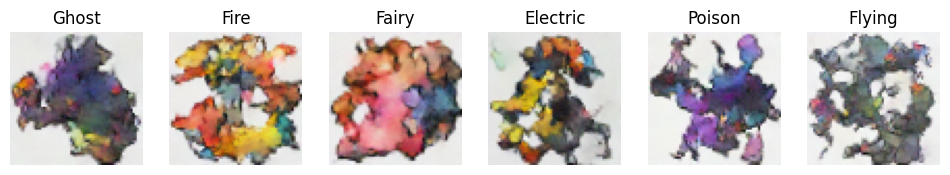

Generating sample 1/6


Sampling sprite: 1000it [00:41, 24.22it/s]                        


Generating sample 2/6


Sampling sprite: 1000it [00:41, 24.38it/s]                        


Generating sample 3/6


Sampling sprite: 1000it [00:40, 24.44it/s]                        


Generating sample 4/6


Sampling sprite: 1000it [00:40, 24.41it/s]                        


Generating sample 5/6


Sampling sprite: 1000it [00:41, 24.21it/s]                        


Generating sample 6/6


Sampling sprite: 1000it [00:40, 24.47it/s]                        


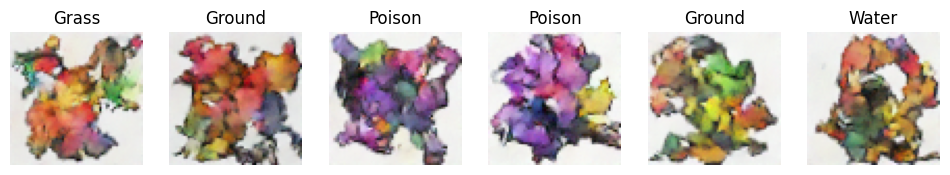

In [15]:
model.plot_samples(6)
model.plot_samples(6)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [16]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "../../models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.keras"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [17]:
# Save the model
SCHEDULER = "linear"
EPOCHS = 600
model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{SCHEDULER}_ddpm"

save_model(model, model_name)

/home/pqlza/.local/lib/python3.11/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


Model diffusion_64_64_600_1000_linear_ddpm, saved successfully!


In [40]:
# load the model
# =====================================================================
model_loaded = tf.keras.models.load_model(f"../../models/{model_name}.keras")

model_load.plot_samples(6)

TypeError: <class 'src.model.overfitting_test.DiffusionModel'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'src.model.overfitting_test', 'class_name': 'DiffusionModel', 'config': {'trainable': True, 'dtype': 'float32'}, 'registered_name': 'DiffusionModel', 'compile_config': {'loss': {'module': 'keras.losses', 'class_name': 'MeanSquaredError', 'config': {'name': 'mean_squared_error', 'reduction': 'sum_over_batch_size'}, 'registered_name': None}, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class 'src.model.overfitting_test.DiffusionModel'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of DiffusionModel from its config.

Received config={'trainable': True, 'dtype': 'float32'}

Error encountered during deserialization: DiffusionModel.__init__() got an unexpected keyword argument 'trainable'

[BACK TO TOP](#top)